In [1]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import random
import os
import json
from tabulate import tabulate
from scipy.stats import kde

In [2]:
def plot_heat_map(x,y,nbins):
    k = kde.gaussian_kde((x,y))
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return plt.pcolormesh(yi, xi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.gist_heat)

In [3]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    

### To Do
* Graph distribution of size
* Graph distribution of size vs number of modis matches 
* Map modis detection around a particular kaggle wildfire
* Could modis detect a fire after "CONT_DATE"?
* Find appropriate error margins
* Evaluate error rate#
* Reduce redundancy in searching for matches from each database

## Load and Process Datasets

### Kaggle

In [4]:
cnx = sqlite3.connect("FPA_FOD_20170508.sqlite")

kaggle = pd.read_sql_query("""
SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE, DISCOVERY_TIME, CONT_DATE, CONT_TIME, FIRE_SIZE 
FROM 'Fires'
ORDER BY LATITUDE DESC
""", cnx)


kaggle['DISCOVERY_DATE'] = pd.to_datetime(kaggle['DISCOVERY_DATE'], origin="julian", unit="D")# - pd.Timestamp(0).to_julian_date(), unit='D')

kaggle['CONT_DATE'] = pd.to_datetime(kaggle['CONT_DATE'], origin="julian", unit="D")# - pd.Timestamp(0).to_julian_date(), unit='D')

kaggle["LATITUDE"] = pd.to_numeric(kaggle["LATITUDE"])
kaggle["LONGITUDE"] = pd.to_numeric(kaggle["LONGITUDE"])


modis_start_date = datetime(2000, 1, 1)
filter_old_data = kaggle["CONT_DATE"] > modis_start_date
kaggle = kaggle[filter_old_data]

### Modis
"fire_archive_M6_91543.json" can be found in the Google Drive folder "datasets"

In [5]:
with open("fire_archive_M6_91543.json", "r") as jfile:
    modis1=json.loads(jfile.read())
    
modis = pd.DataFrame.from_dict(modis1)

modis.columns = modis.columns.map(lambda x: x.upper())

modis["LATITUDE"] = pd.to_numeric(modis["LATITUDE"])
modis["LONGITUDE"] = pd.to_numeric(modis["LONGITUDE"])

modis['ACQ_DATE'] = pd.to_datetime(modis['ACQ_DATE'])

Take smaller sample data sets for testing

In [6]:
# take extract of dataset for testing
smpl_upper_bound = datetime(year=2007, month=4, day=1)
smpl_lower_bound = datetime(year=2007, month=1, day=1)

mf1 = modis["ACQ_DATE"] < smpl_upper_bound
mf1n2 = (modis["ACQ_DATE"] >= smpl_lower_bound) & mf1

modis = modis[mf1n2].copy()

kf1 = kaggle["DISCOVERY_DATE"] < smpl_upper_bound
kf1n2 = (kaggle["CONT_DATE"] >= smpl_lower_bound) & kf1

kaggle = kaggle[kf1n2].copy()

## Sample Datasets

### KAGGLE

In [7]:
print("KAGGLE")
print("Number of wilfires:" + str(len(kaggle)))
print()
print("Earliest and latest fires: ")
min_max = [kaggle["DISCOVERY_DATE"].idxmin(),
           kaggle["CONT_DATE"].idxmax()]

display(kaggle.loc()[min_max, ["DISCOVERY_DATE", "CONT_DATE"]])

print()
print("Sample:")
display(kaggle.head())

KAGGLE
Number of wilfires:6900

Earliest and latest fires: 


,DISCOVERY_DATE,CONT_DATE
372687,1997-08-10,2007-08-10
630417,2001-05-14,2010-05-14



Sample:


,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,DISCOVERY_TIME,CONT_DATE,CONT_TIME,FIRE_SIZE
3859,2006,Campfire,64.780000,-147.350000,AK,2006-06-05,1427,2007-06-05,1515,0.2
13683,2007,Debris Burning,48.948056,-115.108889,MT,2007-03-26,1330,2007-03-26,1630,0.7
15116,2007,Debris Burning,48.888611,-115.143056,MT,2007-03-29,1415,2007-03-29,1700,3.8
23487,2007,Miscellaneous,48.686400,-102.112000,ND,2007-03-01,0700,2007-03-01,0800,0.1
26169,2007,Powerline,48.599100,-113.125100,MT,2007-01-02,1730,2007-01-02,2000,2.0


### MODIS

In [8]:
print("MODIS")
print("Number of wilfires:" + str(len(kaggle)))
print()
print("Earliest and latest fires: ")
min_max = [modis["ACQ_DATE"].idxmin(),
           modis["ACQ_DATE"].idxmax()]

display(modis.loc()[min_max, ["ACQ_DATE", "ACQ_TIME"]])

print()
print("Sample:")
display(modis.head())

MODIS
Number of wilfires:6900

Earliest and latest fires: 


,ACQ_DATE,ACQ_TIME
699190,2007-01-01,0442
725284,2007-03-31,0711



Sample:


,LATITUDE,LONGITUDE,ACQ_DATE,ACQ_TIME,TYPE,BRIGHTNESS,CONFIDENCE,FRP,SATELLITE,TRACK,SCAN,INSTRUMENT,BRIGHT_T31,DAYNIGHT,VERSION
699190,46.6931,-94.9139,2007-01-01,0442,0,305.3,26,28.0,Terra,1.3,1.7,MODIS,266.6,N,6.2
699191,19.3520,-155.0578,2007-01-01,0753,2,316.3,91,148.9,Terra,2.0,4.8,MODIS,288.9,N,6.2
699192,19.3347,-155.0514,2007-01-01,0753,2,314.1,84,130.6,Terra,2.0,4.8,MODIS,290.6,N,6.2
699193,19.3530,-155.0519,2007-01-01,0753,2,313.8,83,132.1,Terra,2.0,4.8,MODIS,289.0,N,6.2
699194,19.3496,-155.0612,2007-01-01,1217,2,345.3,100,67.8,Aqua,1.1,1.2,MODIS,293.6,N,6.2


## Map

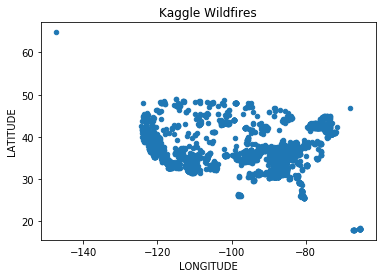

In [9]:
kaggle.plot(x ='LONGITUDE', y='LATITUDE', kind = 'scatter', title="Kaggle Wildfires")

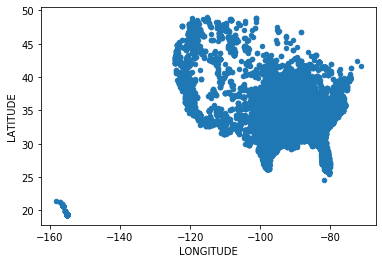

In [10]:
modis.plot(x ='LONGITUDE', y='LATITUDE', kind = 'scatter')

## Heatmap

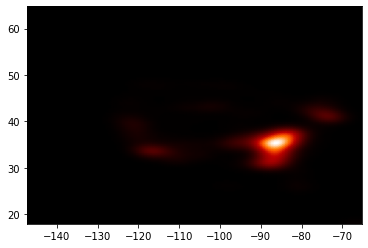

In [11]:
plot_heat_map(kaggle["LATITUDE"], kaggle["LONGITUDE"], 120)

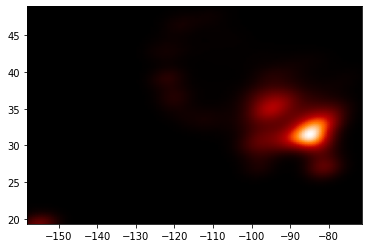

In [12]:
plot_heat_map(modis["LATITUDE"], modis["LONGITUDE"], 120)

# Compare Datasets

## Cross-reference

The below two functions attempt to identify (for each wildfire identified by kaggle) whether there was some MODIS thermal anomaly detected in roughly the same time and place (and vice versa). Each function takes hyperparameters for the acceptable margin of variance in the long/lat coordinates of the datapoints, as well as their dates.

For each wildfire/datapoint in kaggle, it identifies which of the MODIS datapoints might be detections it
For each thermal anomaly detection in MODIS, it identifies which kaggle wildfires might have produced that thermal anomaly

In [13]:
def find_match_indeces_in_modis(k_row, day_margin, lat_margin, long_margin, modis_df):
    lat = k_row["LATITUDE"]
    long = k_row["LONGITUDE"]
    date_disc = k_row["DISCOVERY_DATE"]
    date_cont = k_row["CONT_DATE"]
    
    
    lb = date_disc - timedelta(days=day_margin)
    
    check_time = (lb <= modis_df["ACQ_DATE"]) & (modis_df["ACQ_DATE"] <= date_cont)
    
    check_long = abs(long - modis_df["LONGITUDE"]) < long_margin
    check_lat = abs(lat - modis_df["LATITUDE"]) < lat_margin
    
    return (check_time & check_long & check_lat)

In [14]:
def find_match_indeces_in_kaggle(m_row, day_margin, lat_margin, long_margin, kaggle_df):
    lat = m_row["LATITUDE"]
    long = m_row["LONGITUDE"]
    date_aq = m_row["ACQ_DATE"]    
    
    lb = date_aq + timedelta(days=day_margin)
    
    check_time = (kaggle_df["DISCOVERY_DATE"] <= lb) & (date_aq <= kaggle_df["CONT_DATE"])
    
    check_long = abs(long - kaggle_df["LONGITUDE"]) < long_margin
    check_lat = abs(lat - kaggle_df["LATITUDE"]) < lat_margin
    
    return (check_time & check_long & check_lat)

## Hyperparameter Exploration

The below code attempts to explore the space of space/time error margin hyperparameters to see how it affects the match-rate of our results

* "date_ivs" : is a list of the number of days of error to be allowed in matching the dates

* "ll_ivs" : is a list of the possible number of degrees of error to be allowed in matching the coordinates

* "k_results_hits": is a dictionary where the keys are the hyperparameter pairs and are linked to the results-index this generates
    * e.g. "k_results_hits[(0.01, 1)] = a list of lists: the inner lists each represent all of the MODIS datapoints which map to a particular kaggle wildfire and the outer list holds these lists across all kaggle wildfires

In [ ]:
k_results_hits = {}
k_results_freq = {}

m_results_hits = {}
m_results_freq = {}

# Probably expensive to calculate the actual distance between points
ll_ivs = [0.001, 0.01, 0.1]

date_ivs = [0, 2, 4]

# kag_matches = {}
# mod_matches = {}

for dm in date_ivs:
    for llm in ll_ivs:
        print(llm, dm)
        
        m_finder = lambda x: find_match_indeces_in_modis(k_row=x,
                                                         day_margin=dm,
                                                         lat_margin=llm,
                                                         long_margin=llm,
                                                         modis_df=modis)
        k_hits = kaggle.apply(m_finder, axis=1)
        
#         kag_matches[(llm,dm)] = kaggle.assign(matches=k_hits.values.tolist(),
#                                               num_matches=list(map(sum, k_hits.values.tolist())))
        
        
        k_finder = lambda x: find_match_indeces_in_kaggle(m_row=x,
                                                          day_margin=dm,
                                                          lat_margin=llm,
                                                          long_margin=llm,
                                                          kaggle_df=kaggle)
        
        m_hits = modis.apply(k_finder, axis=1)

#         mod_matches[(llm,dm)] = modis.assign(matches = m_hits.values.tolist(), 
#                                              num_matches = list(map(sum, m_hits.values.tolist())))
        
    
        k_results_hits[(llm,dm)] = k_hits
        
        m_results_hits[(llm,dm)] = m_hits

0.001 0
0.01 0
0.1 0


In [ ]:
k_no_hits_by_row = {}
m_no_hits_by_row = {}
for dm in date_ivs:
    for llm in ll_ivs:     
        k_no_hits_by_row[(llm,dm)] = k_results_hits[(llm,dm)].apply(sum)
        m_no_hits_by_row[(llm,dm)] = m_results_hits[(llm,dm)].apply(sum)

In [ ]:
print(tabulate(display_grid))

In [ ]:
def show_hyperparam_comp(hits_by_row):
    
    f, axs = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(8,10))

    for a0, ax in enumerate(axs):
        llm = ll_ivs[a0]

        d1 = [hits_by_row[(llm,dm)] for dm in date_ivs]
        ls = ["Days: " + str(dm) for dm in date_ivs]

        ax.hist(d1, label=ls, bins = [0, 1, 2, 3, 4, 5])
        ax.legend(loc='upper right')
        ax.set_title("Lat/Long error margin = " + str(llm))

        ax.set_yscale("log")

    plt.show()

## How many times is each kaggle-reported fire identified by a MODIS data point?

In [ ]:
show_hyperparam_comp(k_no_hits_by_row)

## How many kaggle-reported fires could each MODIS data-point be detecting?

In [ ]:
show_hyperparam_comp(m_no_hits_by_row)